In [ ]:
import pandas as pd 
import numpy as np
class network:
    def __init__(self):
        ## in network werden alle verbindungen zwischen nodes gespeichert
        ## in neode info, die node id, p= die hürde mit der er seine farbe ändert
        ## und c= die farbe die er hat, dabei wird die farbe mit 0 und 1 angegeben

        self.network = pd.DataFrame(columns=['node1', 'node2'])
        self.nodeInfo = pd.DataFrame(columns=['nodeId','p','c']) 

    
    def add_node (self,nodeId:int = None,p:float = None, c:int = None, info_as_list:list=[],):
        ''''info is a list of 1.nodeId, 2. p value, 3. colore''' 
        if info_as_list != []:
            nodeId = info_as_list[0]
            p = info_as_list[1]
            c = info_as_list[2]

        if nodeId in self.nodeInfo.nodeId:
            print (f'could not add node {nodeId}, node allready in network')
            return
        self.nodeInfo.loc[len(self.nodeInfo)] = [nodeId,p,c]
    def add_connection(self, connection:list):
        for i in connection:
            if i not in self.nodeInfo['nodeId'].to_list():
                print(f'could not add connection, you need to add node {i} first')
                return
        self.network.loc[len(self.network)] = connection

    def update_node_c (self,node:int,c:int):
        """
        ändert die farbe eines nodes 
        
        Prams:
        node int: die Id des nodes der geändert werden soll
        c int: die Farbe die der Node bekommen soll

        Return:
        None 

        """
        index = self.nodeInfo.query(f'nodeId =={node}').index[0]
        self.nodeInfo.at[index,'c'] = c
        return None

    def return_network(self):
        return self.network
    
    def find_all_conection_of_node(self, node:int):
        ## sucht alle direkten nachbar von einem node raus 
            
        filterNode1 = self.network.query(f'node1 == {node}').node2
        filterNode2 = self.network.query(f'node2 == {node}').node1
        combinNodes = list(set(filterNode1.to_list()+filterNode2.to_list()))
        return combinNodes
    
    def check_for_path(self, node):
        ## sucht alle nodes raus zu denen ein node irgendwie kontakt aufbauen kann.
        ## dies ist quasi das cluster in dem der node sich befindet
    
        allPossibleConections = []
        testedNodes =[]
        ## ich füge den node selbst hier hinzu für den fall das wenn er keine connection hat er trozdem eine mit sich selbst hat
        allPossibleConections = [node]+self.find_all_conection_of_node(node)
        for connectionNode in allPossibleConections:
            nextConnections = self.find_all_conection_of_node(connectionNode)
            for nc in nextConnections:
                if nc not in allPossibleConections:
                    allPossibleConections.append(nc)            
        return allPossibleConections
    
    def test_if_c_is_color(self,node:int, c:int)->bool:
        """
        test if a color of node is the int

        paras: 
        node int : the id of the node to test
        c int : the color which is to test

        retunr:
        bool : True if the node has the color
        """
        ## testet die farbe des nodes 
        result = self.nodeInfo.query(f'nodeId =={node}').c 
        if not result.empty and result.iloc[0]==c:
            return True
        else:
            return False
    
    def get_mean_c_of_node(self, node:int)->float:
        ## hier wird sich die farbe aller nachbarn eines nodes angeschaut und der mittelwert davon ausgegeben
        nodeList = self.find_all_conection_of_node(node)
        cList = []
        for node in nodeList:
            cList.append(self.nodeInfo.query(f'nodeId == {node}').c.to_numpy()[0])
        meanOfC = np.mean(cList)
        #print(f'node {node} has mean {meanOfC}')
        return(meanOfC)

    def get_color_count_of_node(self, node:int, relativ:bool = True)->float:
        """
        count the colores of the neighbors of a given node.

        Paras:
        node int : the id of the node to test
        relativ bool: changes modus to return the relativ size compard to num of neigbors

        Return:
        dict: the count of all colores 
        """
        from collections import Counter
        nodeList = self.find_all_conection_of_node(node)
        cList = []
        for node in nodeList:
            cList.append(int(self.nodeInfo.query(f'nodeId == {node}').c.to_numpy()[0]))
        count = dict(Counter(cList))
        if relativ == True:
            count = {key:value/len(cList) for key, value in count.items()}
        return (count)
    
    
    def get_p_of_node(self,node)->float:
        ## gibt p eines nodes zurück
        ## das zeigt an wie hoch mean c seines umfeldes sein muss das er seine farbe ändert
        result = self.nodeInfo.loc[self.nodeInfo['nodeId'] == node, 'p']
        if result.empty:
                raise ValueError(f"No matching node found for nodeId: {node}")
            
        return result.iloc[0]
    
    def check_c_change_of_singel_node(self,node:int)->bool:
        ## schaut ob sie die farbe eines einzelnen nodes ändert und ändert sie 
        ## gibt true zurück wenn sie sich geändert hat 
        ## ändert nie zu weiß(0) zurück

        count = self.get_color_count_of_node(node=node)
        
        ## if node has no connections return false
        if count == {}:
            return False
        
        most_c, share_of_c = list(count.items())[0]
        ## node can not change back to 0
        if most_c == 0:
            return False
        ## if node already has the color 
        if self.test_if_c_is_color(node,most_c):
            return False
        p = self.get_p_of_node(node)
        if share_of_c>p:
            self.update_node_c(node,most_c)
            return True
        return False


    def check_cascade(self, numOfChecks:int = 10**6) ->list:
        """
        Checks for casacdes

        iterates over every node in the network to check if he will swich colore
        stops itatatien if natwork stabel, no node chages colore 
        returns the size of the network 
        
        Parameters:
        numOfChecks int : how often the cascade will check the network, default is 10e6

        Returns:
        list: List of the size of the cascade for every iteration of checking
        """
        ## ruft jeden node auf, schaut ob er seine farbe ändern würde und tut das
        ## ruft sooft jeden node auf bis sich nichts mehr ändert
        ## speichert nachjedem durchgang wie viele jetzt rot sind und gibt es zurück
        counter = 0
        zwischen_stand = []
        exitWhile = False
        while exitWhile == False:
            print('checking chascade ')
            counter += 1
            ## es ändern sich nur die nodes die als nachbar ein node haben welcher nicht 0 ist, deshalb werden einfach alle nachbarn derer getestet
            nodesToCheck = self.nodeInfo.query('c != 0').nodeId.to_list()
            for singleNodeToCheck in nodesToCheck:
                connectionsOfNode = self.find_all_conection_of_node(singleNodeToCheck)
                for singleConnectionNode in connectionsOfNode:
                    self.check_c_change_of_singel_node(singleConnectionNode)
            nodesToCompare = self.nodeInfo.query('c != 0').nodeId.to_list()
            zwischen_stand.append(self.size_of_cascade())
            if nodesToCheck == nodesToCompare:
                exitWhile = True
        return zwischen_stand

    def size_of_cascade(self)->int:
        ## gibt an wie viele nodes die Farbe 1 haben
        return (len(self.nodeInfo['c'][self.nodeInfo['c'] !=0]))
    def generate_a_network_version1 (self,size:int, mean_z:int, p:int):
        """
        generates a new network with given atributs. Generates connections by drawing a sample of nodes.

        Parameters:
        size: int the size of the network that should be genareted
        mean_z: int the mean number of edges the netwrok should have
        p: the value of p each node in the network should have

        Returns:
        DataFrame of the network connetions
        """
    ## hier wird ein netzwerk genneriert in dem aus den existiernenen nodes zufällig eine anzahl an nodes gezogen wird und diese mit einem node verbunden werden.
        for i in range(0,size):
            self.add_node(nodeId=i,p=p,c=0)
        for node in self.nodeInfo.nodeId:
            number_of_connections = abs(int(np.random.normal(loc= mean_z, scale = 0.3*mean_z)))
            connection = np.random.choice(a=self.nodeInfo.nodeId, size=number_of_connections)
            for j in connection:
                self.add_connection([node,j])
            
        return self.network
    
    def generate_a_network_version2 (self,size:int, z:int, p:int):
        """
        generates a new network with given atributs. Generates connections by calculating the probibiltiy of connection to every node.

        Parameters:
        size: int the size of the network that should be genareted
        mean_z: int the mean number of edges the netwrok should have
        p: the value of p each node in the network should have

        Returns:
        DataFrame of the network connetions
        """
        from itertools import combinations
    ## hier wird ein netzwerk genneriert in dem jeder node mit jedem anderen mit der wahrscheinlichkeit von p = z/n eine verbindung aufbaut
        connection_p = z/size
        self.nodeInfo = pd.DataFrame({'nodeId': range(0,size), 'p': [p]*size, 'c':[0]*size})
        possible_connections = list(combinations(self.nodeInfo.nodeId,2))
        connection_probability = np.random.rand(len((possible_connections))) <= connection_p
        connections = [i for i, mask in zip(possible_connections, connection_probability) if mask]
        
        for connection in connections:
            self.add_connection(connection)
        return self.network
    
    def shock_network (self,size:int,c:int)->None:
        """
        changes the colore of random nodes

        Parameters: 
        size: int the number of nodes which colores should change 
        c: int color of the nodes to change to 
        Return:
        None
        """
        ## changes the colour of n random nodes
        if len(self.nodeInfo)<size:
            print(f'WARNING!! the network is to small for the shock, networksize: {len(self.nodeInfo)}')
            return
        shock_nodes = np.random.choice(a=self.nodeInfo.nodeId,size = size,replace=False)
        for node in shock_nodes:
            self.update_node_c(node=node,c=float(c))

    def size_of_conected_cluster(self)->list[int]:
        ## gibt die größe aller connectedter cluster in einem netzwek aus
        size_of_cluster =[]
        nodes_to_check = list(self.nodeInfo.nodeId)
        while nodes_to_check:
            test_node = nodes_to_check[0]
            path = self.check_for_path(test_node)
            size_of_cluster.append(len(path))
            nodes_to_check = [node for node in nodes_to_check if node not in path ]
        size_of_cluster.sort(reverse=True)
        return size_of_cluster

        

In [2]:

n = network()
n.add_node(info_as_list=[1,0.1,1])
n.add_node(info_as_list=[2,0.9,1])
n.add_node(info_as_list=[3,0.9,1])
n.add_node(info_as_list=[4,0.9,2])
n.add_node(info_as_list=[5,0.9,0])
n.add_node(info_as_list=[6,0.9,0])

n.add_node(info_as_list=[9,0.5,2])
n.add_node(info_as_list=[8,0.5,0])
n.add_connection([1,2])
n.add_connection([1,3])
n.add_connection([4,2])
n.add_connection([3,2])
n.add_connection([5,2])
n.add_connection([5,3])
n.add_connection([5,6])

n.add_connection([9,8])

test = n.return_network()
n.nodeInfo

,nodeId,p,c
0,1.0,0.1,1.0
1,2.0,0.9,1.0
2,3.0,0.9,1.0
3,4.0,0.9,2.0
4,5.0,0.9,0.0
5,6.0,0.9,0.0
6,9.0,0.5,2.0
7,8.0,0.5,0.0


In [11]:
n = network()
from collections import Counter
n.generate_a_network_version2(100,4,0.12)
n.shock_network(40,1)
n.check_cascade()
Counter(n.nodeInfo['c'])

checking chascade 
checking chascade 
checking chascade 
checking chascade 


Counter({1: 70, 0: 30})

Counter({0: 93, 2: 7})

In [ ]:
import os 
start_from_save = False
result_df = pd.DataFrame(columns=['z','p','size_of_cascade'])
start_z = 0
start_p = 10

file_name = 'result_df.csv'
if os.path.exists(file_name):
    result_df = pd.read_csv(file_name)
    start_z = result_df['z'].iloc[-1] +1
    last_p = int(result_df['p'].iloc[-1]*100 +1)
    start_from_save = True    
print(f"staring at z: {start_z}, p:{start_p}")

for i in range(start_z,16):
    print(f"run nummebre {i}")
    for j in range(start_p,26,1):
        j = j*0.01
        if j <last_p and start_from_save == True:
            pass
        start_from_save = False
        for _ in range(0,10):
            n = network()
            n.generate_a_network_version2(size=5000,z=i, p=j)
            n.shock_network(size = 30)
            verlauf = n.check_cascade()
            cascade_size = n.size_of_cascade()
            result_df.loc[len(result_df)] = {'z':i,'p':j,'size_of_cascade':cascade_size,'verlauf':verlauf}
        result_df.to_csv(file_name,index=False)




run nummebre 0
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
run nummebre 1
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
checking chascade 
c

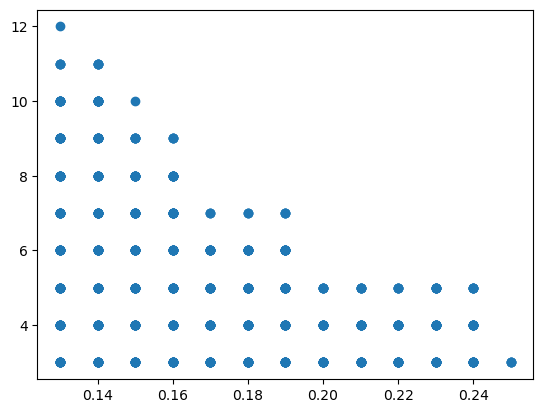

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('result_df_5000_nodes.csv')
filtert_data = data.query('size_of_cascade >90')
plt.scatter(filtert_data['p'],filtert_data['z'],)


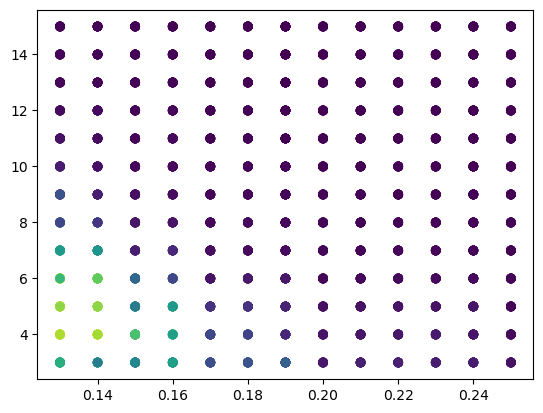

In [ ]:
plt.

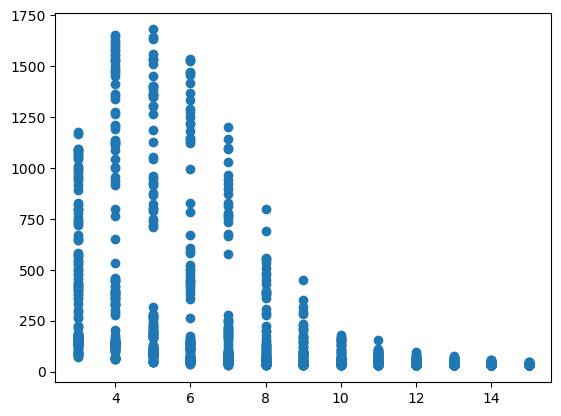

In [25]:
plt.scatter(data['z'],data['size_of_cascade'])

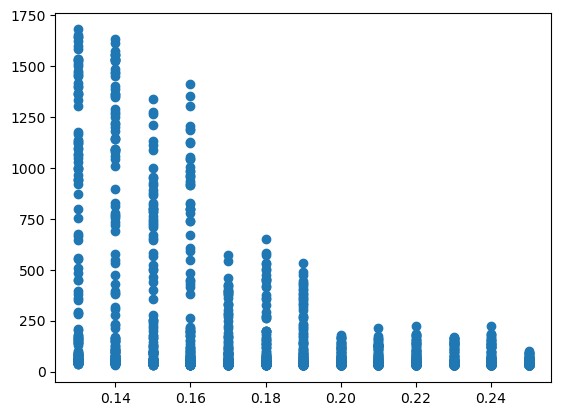

In [26]:
plt.scatter(data['p'],data['size_of_cascade'])

In [ ]:
n = network()
n.generate_a_network_version2(10000,5,0.10)